## Basics

In [ ]:
!pip install lifelines scikit-survival --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [ ]:
data = pd.DataFrame({
    "time": [2,3,4,6,8,10],
    "event": [1,1,0,1,0,1]
})

### Kaplan-Meier survival curve

Estimate the probability of surviving past time t by multiplying the “chance of surviving” each time an event happens.

Example:<br>
|Patient|Time(months)|Event happened?|
|:--:|:--:|:--:|
|A|2|yes|
|B|3|yes|
|C|4|censored|
|D|6|yes|
|E|8|censored|

Event times are: 2, 3, 6
|Time|Still alive before|Events|"Survive past this point" probability|	Cumulative survival|
|:-:|:-:|:-:|:-:|:--:|
|2|5|1|	4/5 = 0.8|	0.8|
|3|4|1|	3/4 = 0.75|	0.8 x 0.75 = 0.6|
|6|2|1|	1/2 = 0.5|	0.6 x 0.5 = 0.3|


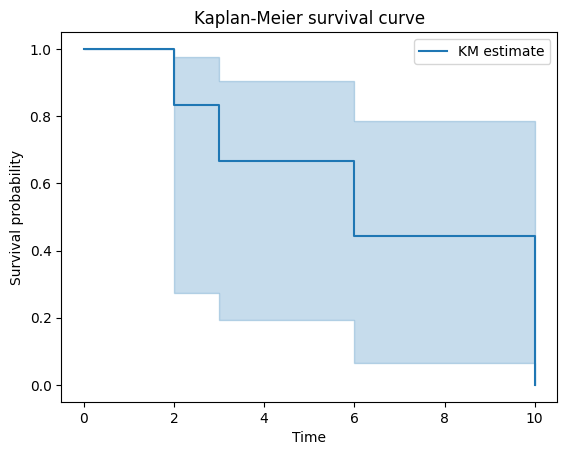

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(data["time"], event_observed=data["event"], label="KM estimate")

kmf.plot_survival_function(ci_show = True)
plt.title("Kaplan-Meier survival curve")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.show()

### Nelson-Aalen cumulative hazard

While KM focuses on survival, Nelson-Aalen estimates the "cumulative hazard", or the total risk accumulated up to each time.

Then survival can be approximated as:
- **Survival ≈ exp(- cumulative hazard)**

Example:<br>
|Time|Still alive before|Events|Hazard step (Event / Alive)|Cumulative hazard|
|:-:|:-:|:-:|:-:|:--:|
|2|5|1|1/5 = 0.2|0.2|
|3|4|1|1/4 = 0.25|0.2 + 0.25 = 0.45|
|6|2|1|1/2 = 0.5|0.45 + 0.5 = 0.95|

Survival ≈ exp(-0.95) ≈ 0.39

Compare with KM estimate (0.3) — similar, just slightly different calculation style.

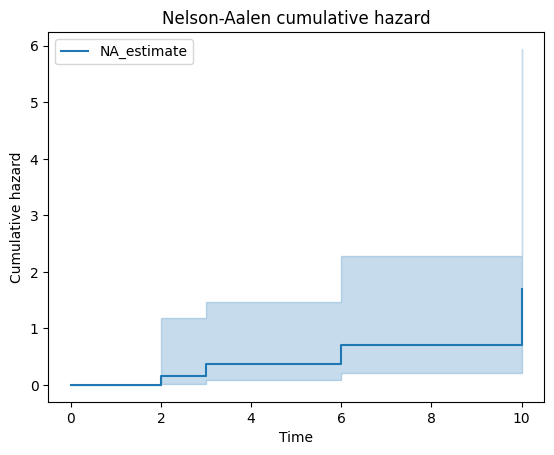

In [ ]:
from lifelines import NelsonAalenFitter

naf = NelsonAalenFitter()
naf.fit(data["time"], event_observed=data["event"])

naf.plot_cumulative_hazard()
plt.title("Nelson-Aalen cumulative hazard")
plt.xlabel("Time")
plt.ylabel("Cumulative hazard")
plt.show()

### Cox Proportional Hazards model (supervised baseline)

In [ ]:
from lifelines import CoxPHFitter

# Add a covariate (feature)
data["age"] = [40, 50, 35, 60, 55, 45]

cph = CoxPHFitter()
cph.fit(data, duration_col="time", event_col="event")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 6 total observations, 2 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 6
number of events observed = 4
   partial log-likelihood = -4.50
         time fit was run = 2025-10-09 15:51:23 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.00      1.00      0.07           -0.14            0.14                0.87                1.16

           cmp to    z    p  -log2(p)
covariate                            
age          0.00 0.01 0.99      0.01
---
Concordance = 0.45
Partial AIC = 11.00
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.01

### Predicting survival for each person

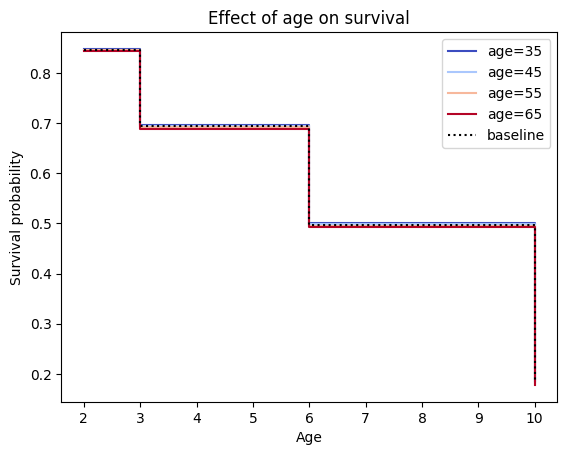

In [ ]:
cph.plot_partial_effects_on_outcome('age', [35,45,55,65], cmap='coolwarm')
plt.title("Effect of age on survival")
plt.xlabel("Age")
plt.ylabel("Survival probability")
plt.show()

### Scikit-survival

In [ ]:
import numpy as np
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

data_x, data_y = load_veterans_lung_cancer()
data_x.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard


In [ ]:
data_y[:5]

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import pandas as pd

# Convert categorical features to numerical using one-hot encoding
data_x_encoded = pd.get_dummies(data_x, columns=['Celltype', 'Prior_therapy', 'Treatment'], drop_first=True)

model = CoxPHSurvivalAnalysis()
model.fit(data_x_encoded, data_y)

CoxPHSurvivalAnalysis()

### This is the **concordance index** (C-index), the main metric used to evaluate survival models.
- After you train your Cox proportional hazards model, this gives you risk scores for each person in the dataset.
- Each value = estimated risk of event
- These are not probabilities, but relative risks. <br>

- event_observed: Boolean array → True if the event happened, False if censored
(in your dataset: data_y['Status'])
- event_time: Time until event or censoring
- predicted_risk: The predicted risk scores from your model.

In [ ]:
pred = model.predict(data_x_encoded)
c_index = concordance_index_censored(data_y['Status'], data_y['Survival_in_days'], pred) # concordance_index_censored(event_observed, event_time, predicted_risk)
print("Concordance index:", c_index)

Concordance index: (np.float64(0.7362562471603816), np.int64(6482), np.int64(2322), np.int64(0), np.int64(7))


|Position|Meaning|Example Value|Explanation|
|:------:|:-----:|:-----------:|:---------:|
|[0]|C-index value|0.736|This is the main number you care about → <br>the model correctly orders 73.6% of comparable pairs|
|[1]|Number of concordant pairs|6482|How many pairs the model ranked correctly|
|[2]|Number of discordant pairs|2322|How many pairs the model ranked incorrectly|
|[3]|Number of tied pairs| 0|Cases where risk scores were identical|
|[4]|Number of comparable pairs ignored|7|Pairs not comparable due to censoring structure|


**C-index:**
Imagine comparing every pair of patients (A, B):
- If A dies earlier than B, and model gives A higher risk → ✅ concordant
- If A dies earlier, but model gives A lower risk → ❌ discordant
- If one is censored before the other's event → can't compare

### Kaplan-Meier again


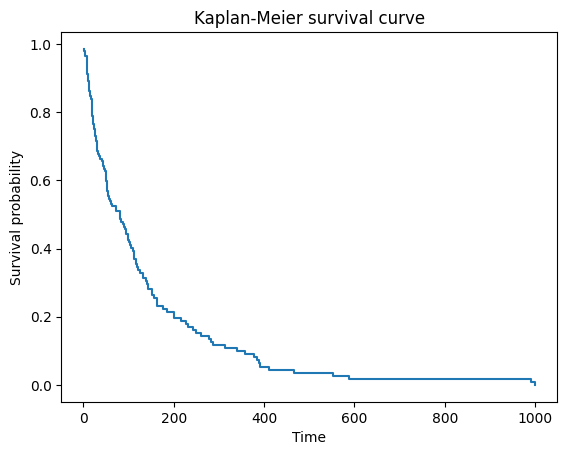

In [ ]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y['Status'], data_y['Survival_in_days'])

plt.step(time, survival_prob, where="post")
plt.title("Kaplan-Meier survival curve")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.show()

## Deep Learning for Survival Analysis

### DeepSurv: Neural Cox Model

DeepSurv = a neural network version of the Cox Proportional Hazards model <br>
It replaces the linear predictor βᵀx from Cox with a neural network fθ(x).

This means:<br>
It learns non-linear relationships between features and risk, but still uses Cox's loss function.

**When to use it**
- When relationships between covariates and survival are *nonlinear or complex* (e.g., images, genomics, patient records)
- You still assume **propotional hazards** (the risk ratio between two patients stays constant over time)

**How it works**
1. Input features → Neural network → outputs a "risk score" per sample
2. Trained with **Cox partial likelihood** (so censored data handled correctly)
3. Output: relative risk (higher = earlier event)

In [ ]:
!pip install scikit-survival pycox torchtuples --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.9/429.9 kB 14.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torchtuples as tt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pycox.models import CoxPH
from sksurv.datasets import load_whas500
from sksurv.metrics import concordance_index_censored

In [ ]:
# Load dataset
data_x, data_y = load_whas500()

df_y = pd.DataFrame.from_records(data_y)
df_x = pd.DataFrame(data_x)

df = pd.concat([df_x, df_y], axis=1)
df.head()

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp,fstat,lenfol
0,1,83.0,0,25.54051,0,1,78.0,0,89.0,5.0,1,0,0,152.0,False,2178.0
1,0,49.0,0,24.02398,0,1,60.0,0,84.0,5.0,0,1,0,120.0,False,2172.0
2,0,70.0,0,22.14290,0,0,88.0,1,83.0,5.0,0,1,0,147.0,False,2190.0
3,0,70.0,0,26.63187,1,1,76.0,0,65.0,10.0,0,1,0,123.0,True,297.0
4,0,70.0,0,24.41255,0,1,85.0,0,63.0,6.0,0,1,0,135.0,False,2131.0


In [ ]:
durations = df["lenfol"].values.astype(np.float32)
events = df["fstat"].astype(int).values.astype(np.float32)

X_train, X_test, dur_train, dur_test, ev_train, ev_test = train_test_split(
    df_x.values.astype(np.float32),
    durations,
    events,
    test_size=0.2,
    random_state=42,
    stratify=events
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = (dur_train, ev_train)
y_test = (dur_test, ev_test)

In [ ]:
# Build neural network
net = torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1], 64),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(64),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
)

In [ ]:
# CoxPH model (DeepSurv)
model = CoxPH(net, tt.optim.Adam(lr=1e-4))
model.fit(X_train, y_train, batch_size=64, epochs=200, verbose=True)

0:	[0s / 0s],		train_loss: 3.4803
1:	[0s / 0s],		train_loss: 3.4506
2:	[0s / 0s],		train_loss: 3.4207
3:	[0s / 0s],		train_loss: 3.4492
4:	[0s / 0s],		train_loss: 3.3527
5:	[0s / 0s],		train_loss: 3.3612
6:	[0s / 0s],		train_loss: 3.4120
7:	[0s / 0s],		train_loss: 3.3598
8:	[0s / 0s],		train_loss: 3.3771
9:	[0s / 0s],		train_loss: 3.3193
10:	[0s / 0s],		train_loss: 3.3881
11:	[0s / 0s],		train_loss: 3.3594
12:	[0s / 0s],		train_loss: 3.3021
13:	[0s / 0s],		train_loss: 3.3317
14:	[0s / 0s],		train_loss: 3.3436
15:	[0s / 0s],		train_loss: 3.3129
16:	[0s / 0s],		train_loss: 3.3073
17:	[0s / 0s],		train_loss: 3.2980
18:	[0s / 0s],		train_loss: 3.3448
19:	[0s / 0s],		train_loss: 3.2911
20:	[0s / 0s],		train_loss: 3.3283
21:	[0s / 0s],		train_loss: 3.2561
22:	[0s / 0s],		train_loss: 3.2336
23:	[0s / 1s],		train_loss: 3.2712
24:	[0s / 1s],		train_loss: 3.2596
25:	[0s / 1s],		train_loss: 3.2186
26:	[0s / 1s],		train_loss: 3.2494
27:	[0s / 1s],		train_loss: 3.1988
28:	[0s / 1s],		train_loss: 3.

In [ ]:
# Predict risk scores on test data
risk_scores = model.predict(X_test).reshape(-1)

# Evaluate using concordance index
c_index = concordance_index_censored(ev_test.astype(bool), dur_test, risk_scores)[0]
print("Test Concordance Index:", c_index)

Test Concordance Index: 0.8178368121442126


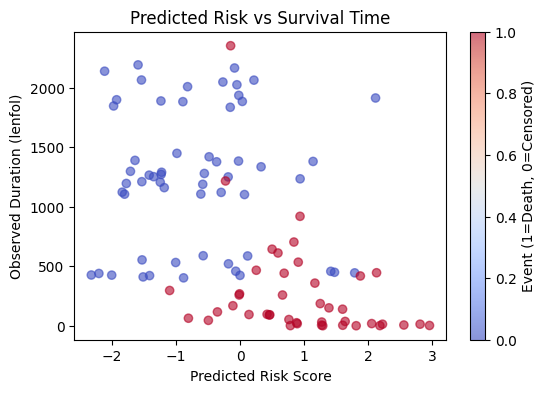

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(risk_scores, dur_test, c=ev_test, cmap="coolwarm", alpha=0.6)
plt.xlabel("Predicted Risk Score")
plt.ylabel("Observed Duration (lenfol)")
plt.title("Predicted Risk vs Survival Time")
plt.colorbar(label="Event (1=Death, 0=Censored)")
plt.show()

**The “sign flip” issue (most common!)**

DeepSurv (and pycox.CoxPH) outputs a risk score, not survival time.

By convention:

Higher risk score → higher hazard → shorter survival time.

But the concordance_index_censored function in scikit-survival assumes that larger predicted values mean longer survival by default.

<Axes: title={'center': 'Predicted Survival Curves (5 Patients)'}, xlabel='duration'>

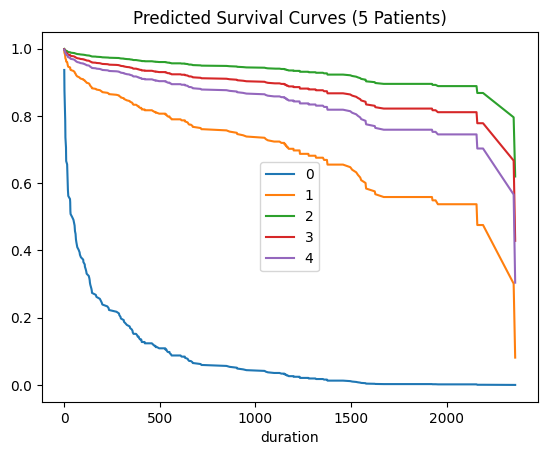

In [ ]:
# Compute baseline hazard and predict survival curves
model.compute_baseline_hazards()
surv_df = model.predict_surv_df(X_test[:5])  # for first 5 patients
surv_df.plot(title="Predicted Survival Curves (5 Patients)")

#### Final sanity check with classical Cox model

In [ ]:
from lifelines import CoxPHFitter

df_full = pd.concat([pd.DataFrame(X_train, columns=df_x.columns),
                     pd.Series(dur_train, name="duration"),
                     pd.Series(ev_train, name="event")], axis=1)
cph = CoxPHFitter()
cph.fit(df_full, duration_col="duration", event_col="event")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 400 total observations, 228 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 400
number of events observed = 172
   partial log-likelihood = -859.05
         time fit was run = 2025-10-21 16:53:35 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
afb        0.09      1.10      0.07           -0.05            0.23                0.95                1.26
age        0.62      1.86      0.11            0.40            0.84                1.50                2.31
av3        0.04      1.04      0.07           -0.11            0.18                0.90                1.20
bmi       -0.19      0.83      0.10           -0.39            0.01                0.68                1.01
chf        0.36      1.43      0.08            0.20            0.51                1.23                1.67
cvd       -0.07      0.93      0.09           -0.24            0.10                0.79                1.10
diasbp    -0.19      0.82      0.13           -0.45            0.06                0.64                1.06
gender    -0.14      0.87      0.08           -0.30            0.02                0.74                1.02
hr         0.25      1.28      0.09            0.08            0.42                1.08                1.52
los        0.02      1.02      0.08           -0.13            0.17                0.88                1.18
miord      0.02      1.02      0.08           -0.14            0.17                0.87                1.19
mitype    -0.24      0.79      0.10           -0.44           -0.04                0.64                0.97
sho        0.21      1.23      0.07            0.07            0.35                1.07                1.42
sysbp      0.01      1.01      0.12           -0.22            0.24                0.81                1.28

           cmp to     z      p  -log2(p)
covariate                               
afb          0.00  1.31   0.19      2.38
age          0.00  5.61 <0.005     25.60
av3          0.00  0.52   0.60      0.73
bmi          0.00 -1.87   0.06      4.02
chf          0.00  4.58 <0.005     17.74
cvd          0.00 -0.83   0.41      1.30
diasbp       0.00 -1.49   0.14      2.87
gender       0.00 -1.76   0.08      3.66
hr           0.00  2.89 <0.005      8.04
los          0.00  0.25   0.80      0.32
miord        0.00  0.20   0.84      0.25
mitype       0.00 -2.30   0.02      5.55
sho          0.00  2.95 <0.005      8.31
sysbp        0.00  0.12   0.91      0.14
---
Concordance = 0.77
Partial AIC = 1746.10
log-likelihood ratio test = 162.61 on 14 df
-log2(p) of ll-ratio test = 88.61

#### Another DeepSurv example

In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy as dc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import lifelines.datasets
import torch
import torchtuples as tt
from pycox.models import CoxPH, CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv
np.random.seed(1998)
_ = torch.manual_seed(1998)

In [ ]:
df = lifelines.datasets.load_dd().drop(columns=['politycode', 'cowcode2', 'leaderspellreg'])
df.sample(10)

,ctryname,un_region_name,un_continent_name,ehead,democracy,regime,start_year,duration,observed
1740,Uruguay,South America,Americas,Juan Bordaberry Arocena,Democracy,Presidential Dem,1972,1,1
97,Bangladesh,Southern Asia,Asia,Abu Sadat Mohammad Sayem,Non-democracy,Civilian Dict,1975,2,1
1409,Solomon Islands,Melanesia,Oceania,Francis Billy Hilly,Democracy,Parliamentary Dem,1993,4,1
1306,Romania,Eastern Europe,Europe,Georghe Gheorghiu-Dej,Non-democracy,Civilian Dict,1946,8,1
206,Brazil,South America,Americas,Humberto de Alencar Castello Branco,Non-democracy,Military Dict,1964,3,1
545,France,Western Europe,Europe,Rene Pleven,Democracy,Parliamentary Dem,1950,2,1
1601,Tanzania,Eastern Africa,Africa,Jakaya Mrisho Kikwete,Non-democracy,Military Dict,2005,4,0
658,Guinea-Bissau,Western Africa,Africa,Kumba Iala,Democracy,Mixed Dem,2000,3,1
1731,Uruguay,South America,Americas,Martin Etchegoyen,Democracy,Presidential Dem,1959,1,1
1018,Marshall Islands,Micronesia,Oceania,Imata Kabua,Democracy,Parliamentary Dem,1997,3,1


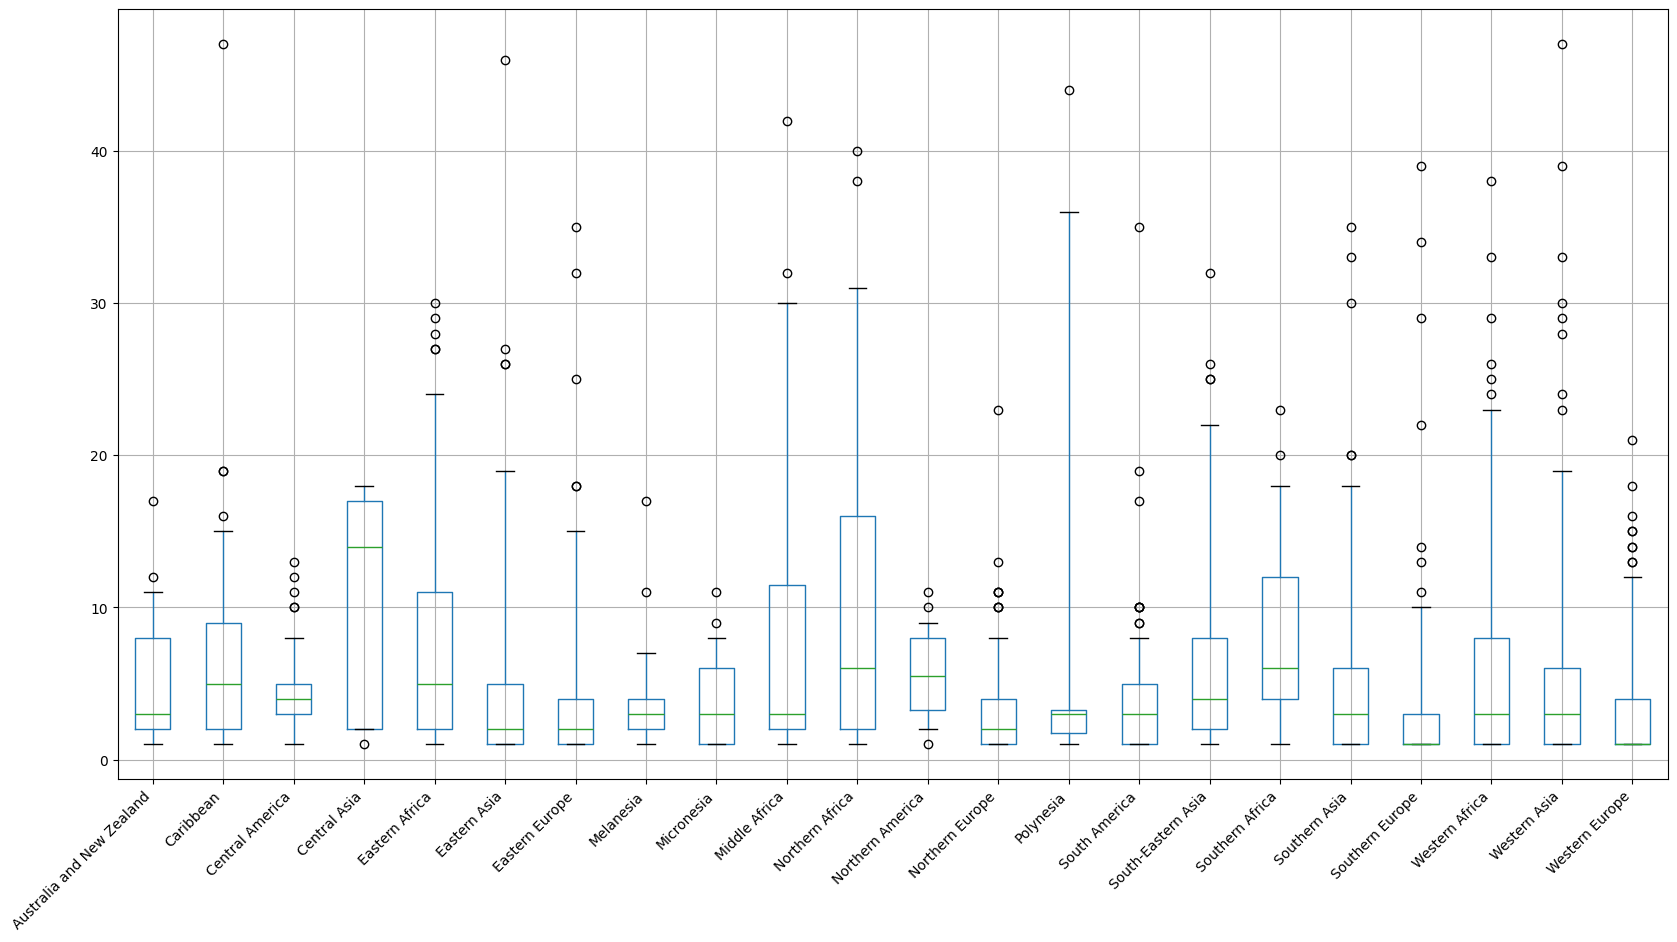

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df.groupby('un_region_name').boxplot(subplots=False, column='duration', ax=ax, rot=45, whis=(5, 95))
plt.draw()
labels = [l.get_text().split(',')[0][1:] for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
plt.show()

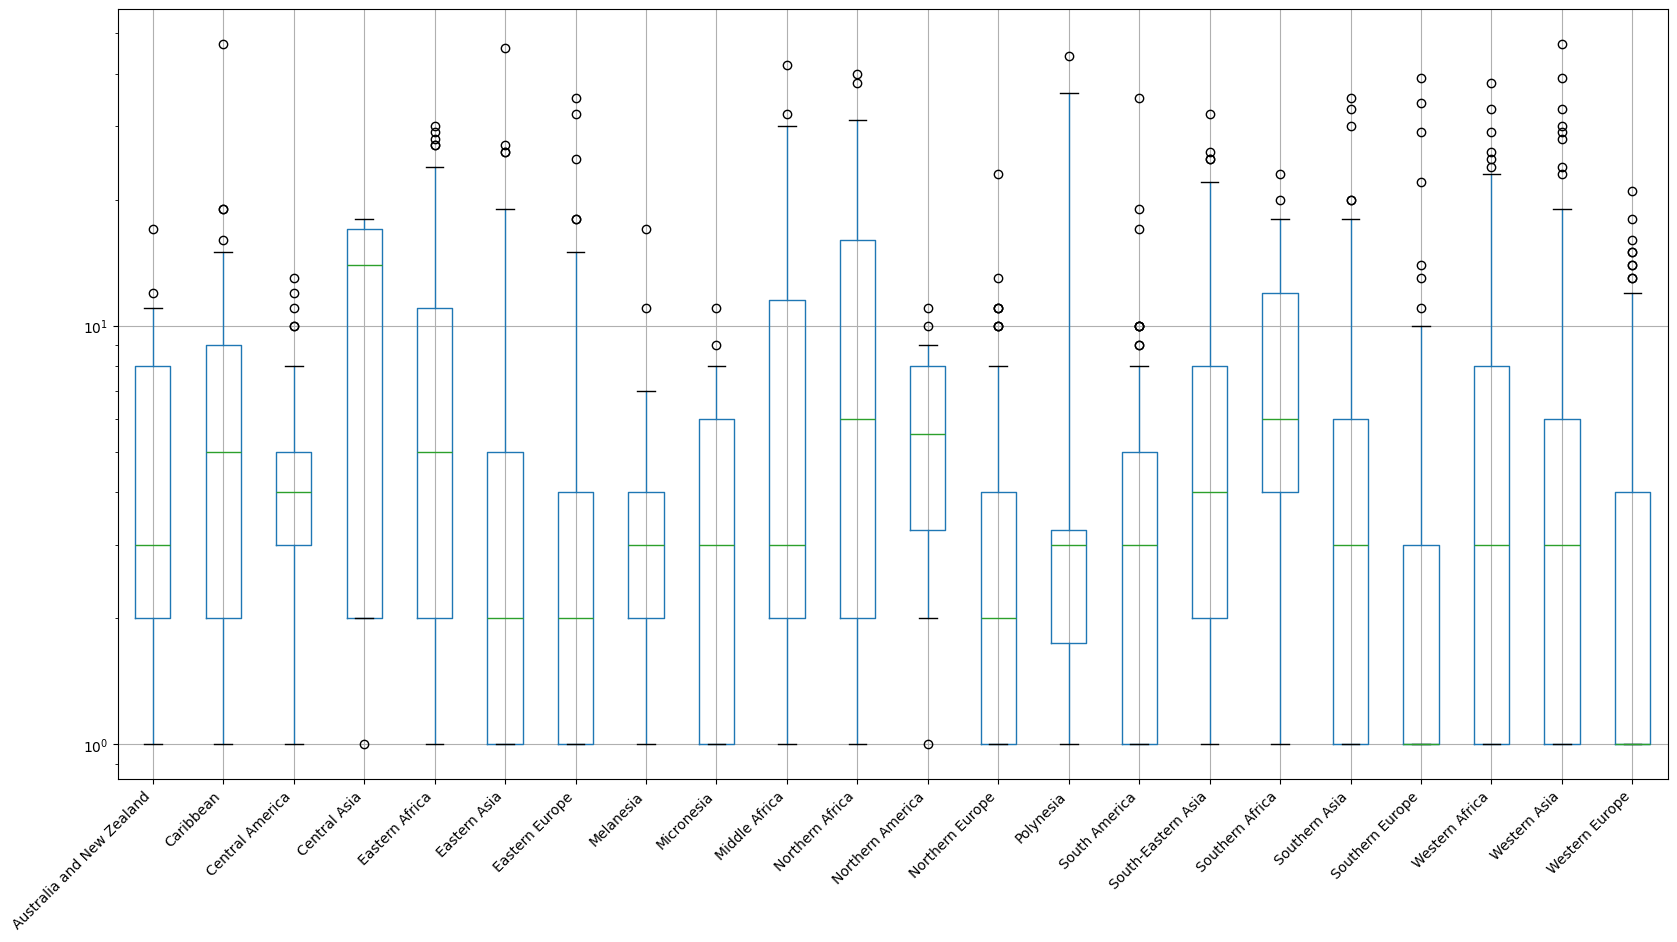

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.set_yscale('log')
df.groupby('un_region_name').boxplot(subplots=False, column='duration', ax=ax, rot=45, whis=(5, 95))
plt.draw()
labels = [l.get_text().split(',')[0][1:] for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
plt.show()

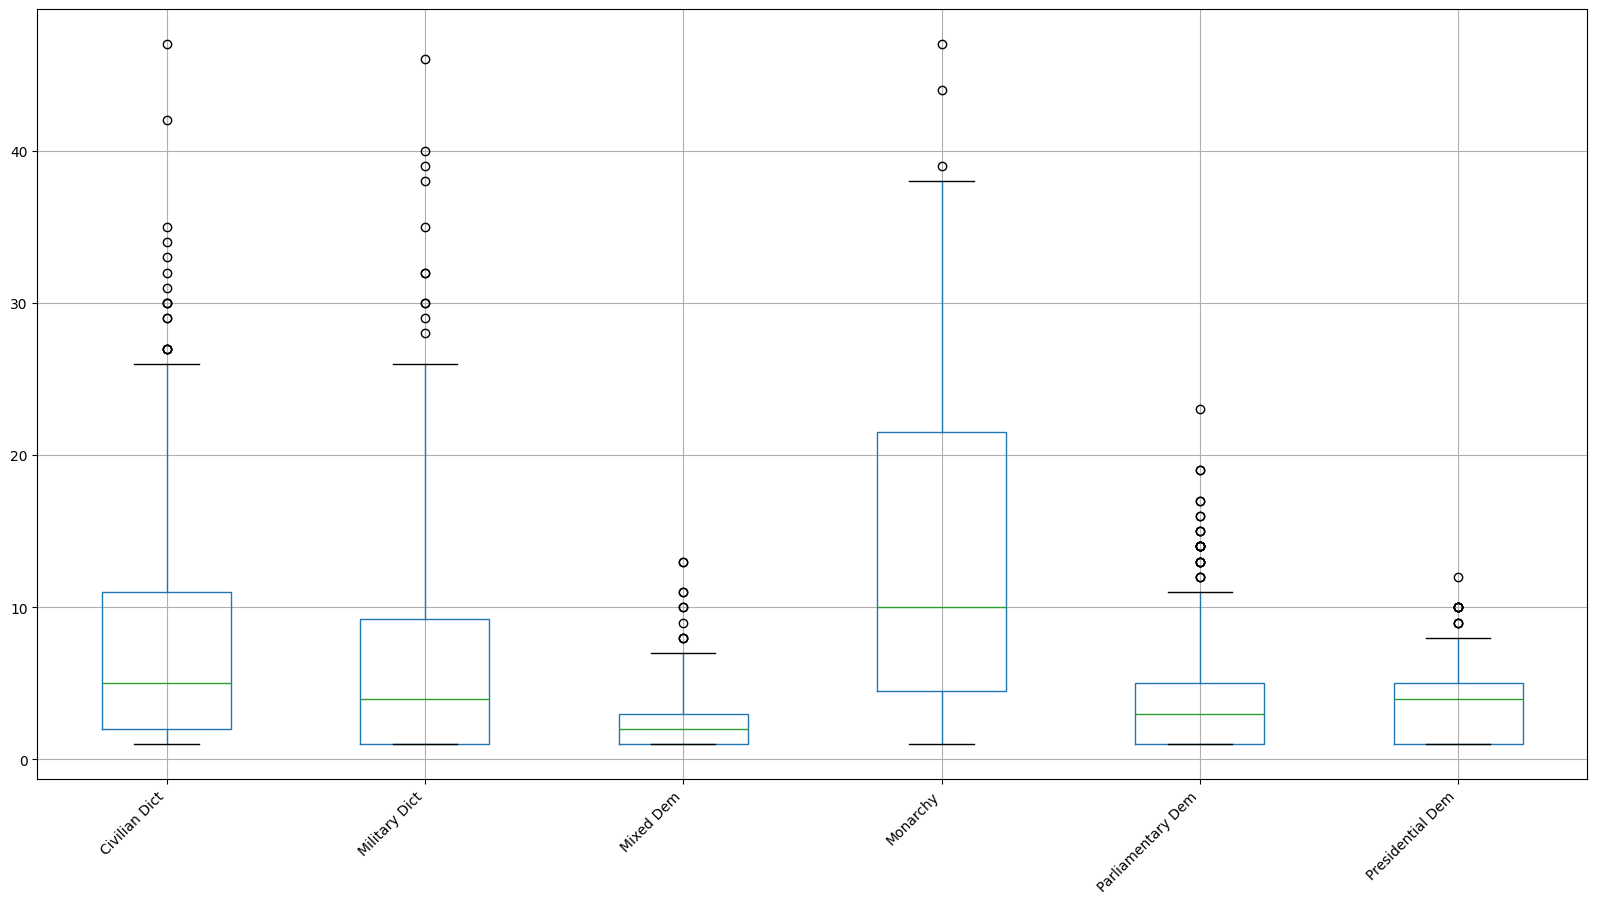

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df.groupby('regime').boxplot(subplots=False, column='duration', ax=ax, rot=45, whis=(5, 95))
plt.draw()
labels = [l.get_text().split(',')[0][1:] for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
plt.show()

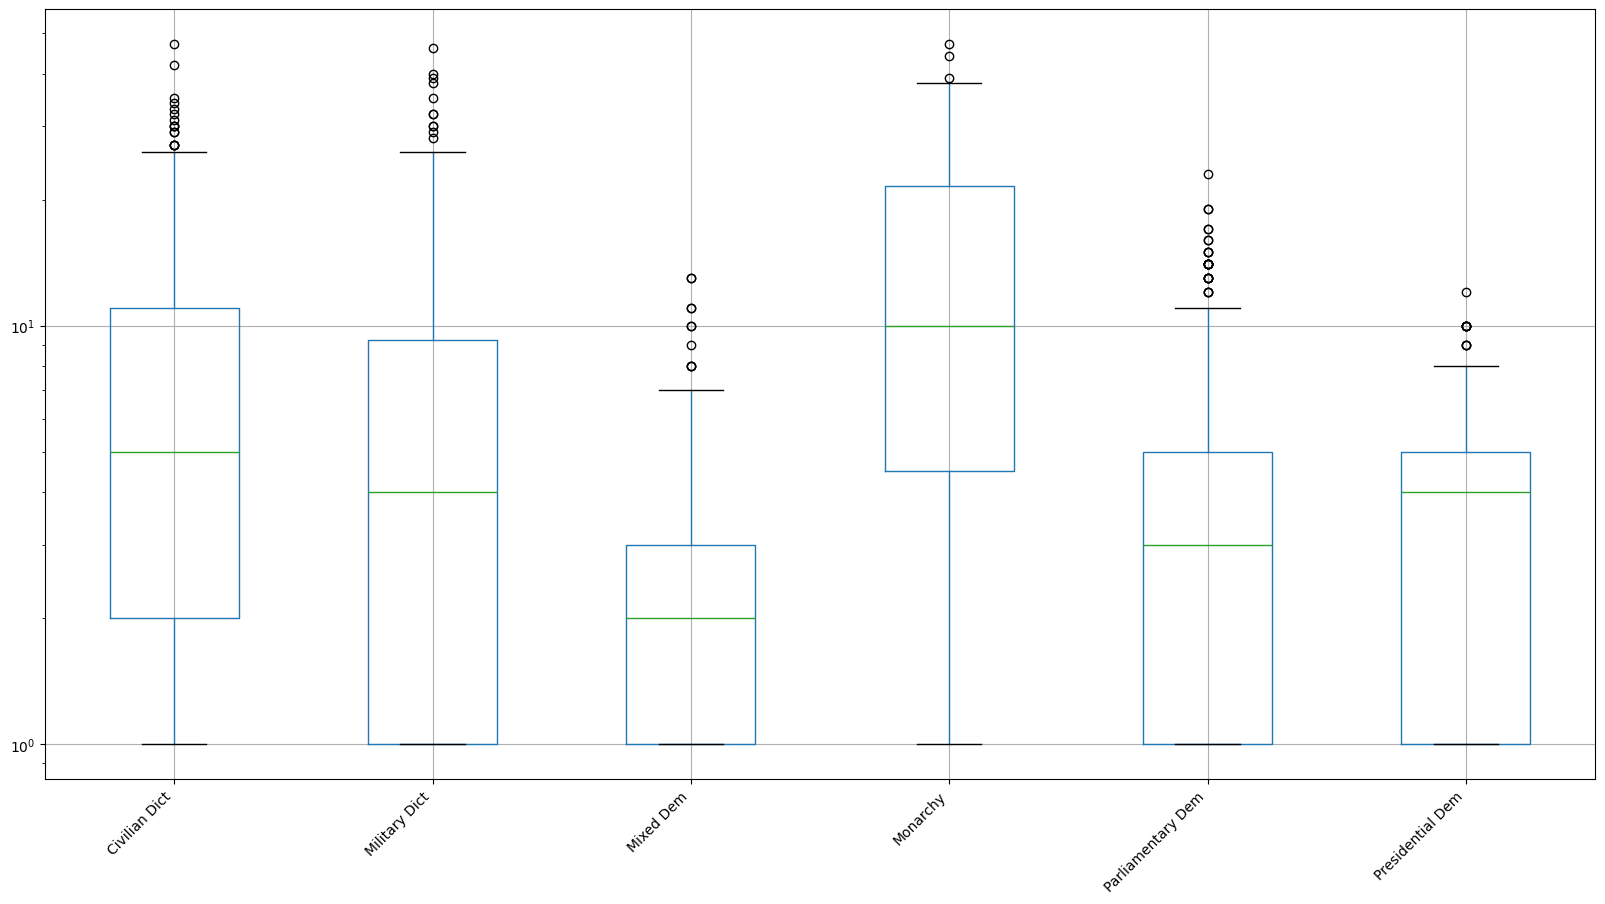

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.set_yscale('log')
df.groupby('regime').boxplot(subplots=False, column='duration', ax=ax, rot=45, whis=(5, 95))
plt.draw()
labels = [l.get_text().split(',')[0][1:] for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
plt.show()

Note: A first bias in this dataset is that it doesn't feature left-truncation : for example, Franco actually came to power in Spain in January 1938 and thus ruled for 37 years instead of 29 as indicated in the database, due to the left-truncation in 1946.

In [ ]:
df.loc[df.duration == df.duration.max()]

,ctryname,un_region_name,un_continent_name,ehead,democracy,regime,start_year,duration,observed
375,Cuba,Caribbean,Americas,Fidel Castro Ruz,Non-democracy,Civilian Dict,1959,47,1
864,Jordan,Western Asia,Asia,Hussein bin Talal,Non-democracy,Monarchy,1952,47,0


In [ ]:
df2 = pd.get_dummies(df.drop(columns=['ehead']), dtype=int)
df2.head()

,start_year,duration,observed,ctryname_Afghanistan,ctryname_Albania,ctryname_Algeria,ctryname_Andorra,ctryname_Angola,ctryname_Antigua & Barbuda,ctryname_Argentina,...,un_continent_name_Europe,un_continent_name_Oceania,democracy_Democracy,democracy_Non-democracy,regime_Civilian Dict,regime_Military Dict,regime_Mixed Dem,regime_Monarchy,regime_Parliamentary Dem,regime_Presidential Dem
0,1946,7,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,1953,10,1,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,1963,10,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1973,5,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,1978,1,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


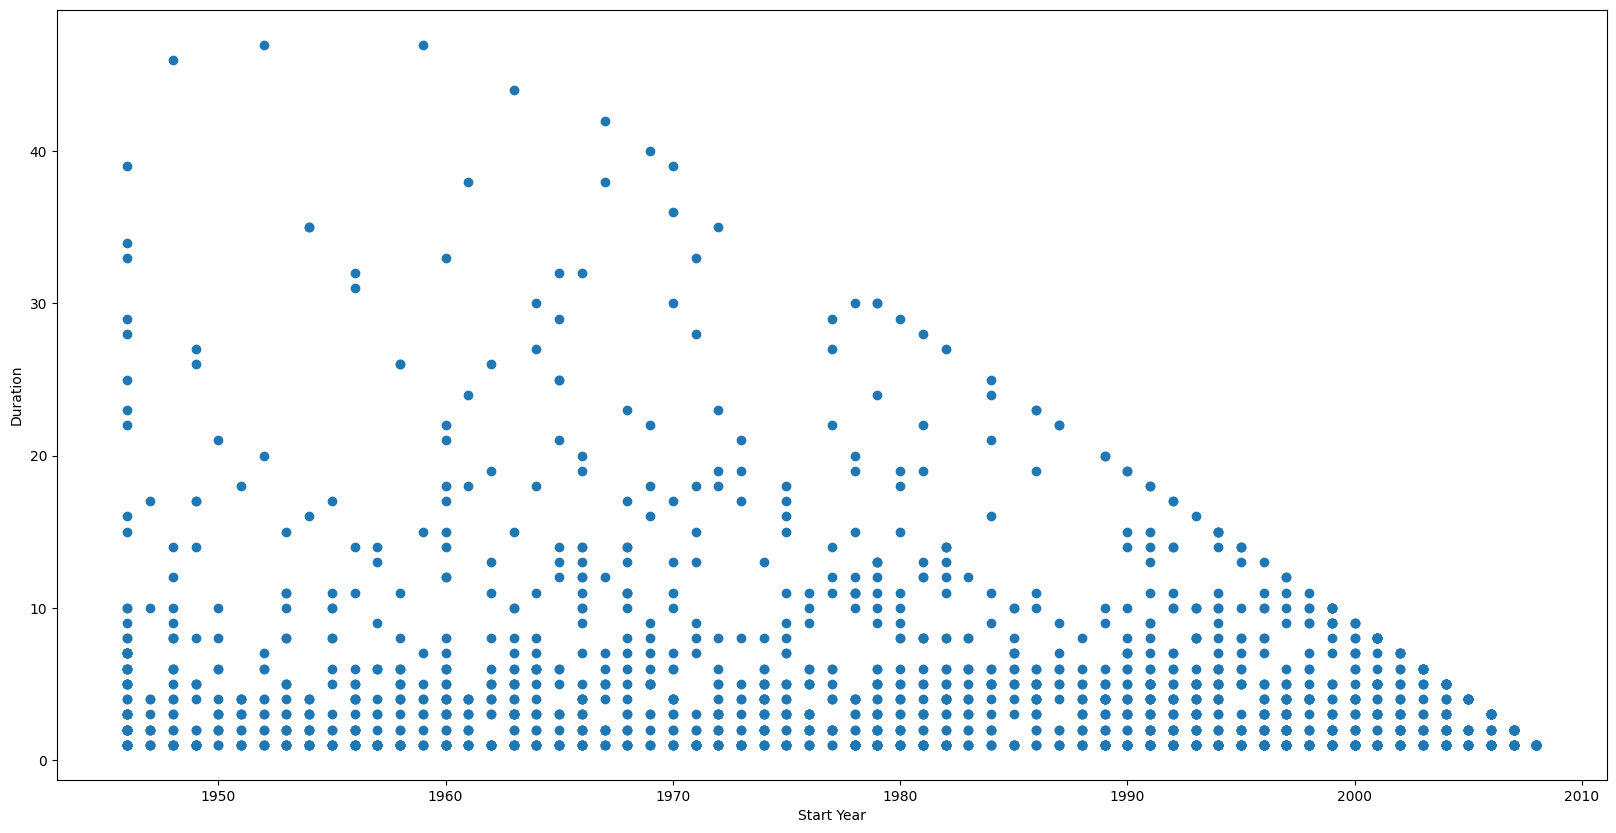

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(df.start_year, df.duration)
ax.set_xlabel('Start Year')
ax.set_ylabel('Duration')
plt.show()

**Proportional Hazards : DeepSurv**

In [ ]:
df_train = dc(df2)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()

,start_year,duration,observed,ctryname_Afghanistan,ctryname_Albania,ctryname_Algeria,ctryname_Andorra,ctryname_Angola,ctryname_Antigua & Barbuda,ctryname_Argentina,...,un_continent_name_Europe,un_continent_name_Oceania,democracy_Democracy,democracy_Non-democracy,regime_Civilian Dict,regime_Military Dict,regime_Mixed Dem,regime_Monarchy,regime_Parliamentary Dem,regime_Presidential Dem
0,1946,7,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,1953,10,1,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,1963,10,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1973,5,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,1978,1,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [ ]:
ssc = StandardScaler()
x_train = ssc.fit_transform(df_train.drop(columns=['duration', 'observed'])).astype('float32')
x_val = ssc.transform(df_val.drop(columns=['duration', 'observed'])).astype('float32')
x_test = ssc.transform(df_test.drop(columns=['duration', 'observed'])).astype('float32')

In [ ]:
get_target = lambda df: (df['duration'].values, df['observed'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

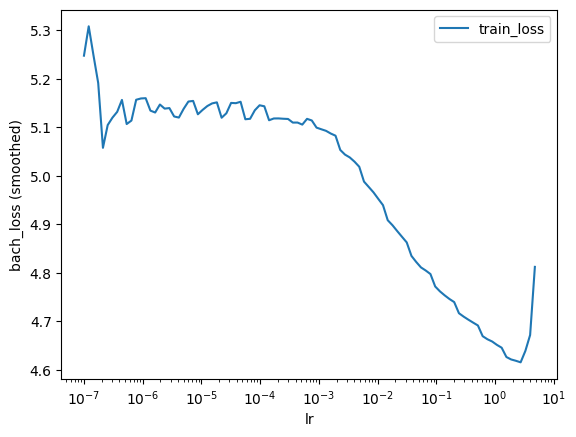

In [ ]:
model = CoxPH(net, tt.optim.Adam)
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()
# Sometimes the optimal learning rate by this methos is too high. If it is higher than 0.01, we set this as the max value

np.float64(0.08902150854450441)

0:	[0s / 0s],		train_loss: 4.6573,	val_loss: 4.6445
1:	[0s / 0s],		train_loss: 4.3815,	val_loss: 4.1387
2:	[0s / 0s],		train_loss: 4.2859,	val_loss: 3.6887
3:	[0s / 0s],		train_loss: 4.2672,	val_loss: 3.7527
4:	[0s / 0s],		train_loss: 4.2197,	val_loss: 3.7563
5:	[0s / 0s],		train_loss: 4.2341,	val_loss: 3.6700
6:	[0s / 0s],		train_loss: 4.1971,	val_loss: 3.6092
7:	[0s / 0s],		train_loss: 4.1643,	val_loss: 3.6673
8:	[0s / 0s],		train_loss: 4.1883,	val_loss: 3.6639
9:	[0s / 0s],		train_loss: 4.1740,	val_loss: 3.6421
10:	[0s / 0s],		train_loss: 4.1562,	val_loss: 3.6715
11:	[0s / 0s],		train_loss: 4.1690,	val_loss: 3.6715
12:	[0s / 0s],		train_loss: 4.1554,	val_loss: 3.6396
13:	[0s / 0s],		train_loss: 4.1330,	val_loss: 3.7401
14:	[0s / 0s],		train_loss: 4.1435,	val_loss: 3.6588
15:	[0s / 0s],		train_loss: 4.1325,	val_loss: 3.7049
16:	[0s / 0s],		train_loss: 4.1164,	val_loss: 3.7358


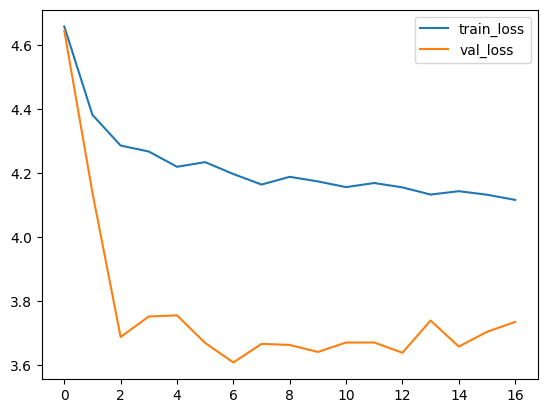

In [ ]:
model.optimizer.set_lr(0.1)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)
_ = log.plot()

In [ ]:
model.partial_log_likelihood(*val).mean()

np.float32(-4.948436)

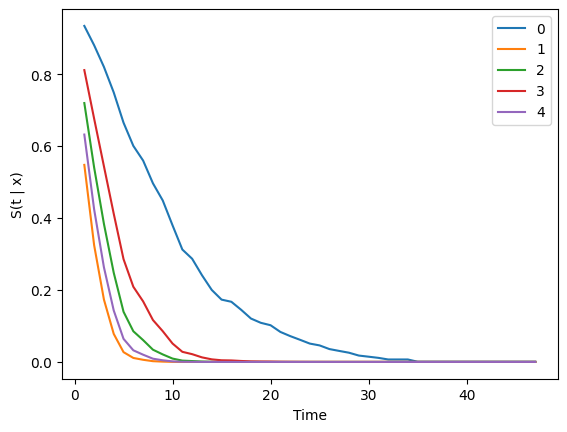

In [ ]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
df.loc[df_test.index[:5]]

,ctryname,un_region_name,un_continent_name,ehead,democracy,regime,start_year,duration,observed
929,Lesotho,Southern Africa,Africa,Leabua Jonathan,Non-democracy,Civilian Dict,1966,20,1
861,Japan,Eastern Asia,Asia,Taro Aso,Democracy,Parliamentary Dem,2008,1,0
124,Belgium,Western Europe,Europe,Theodore Lefevre,Democracy,Parliamentary Dem,1961,4,1
1255,Peru,South America,Americas,Fernando Belaunde Terry,Democracy,Presidential Dem,1980,5,1
909,Lebanon,Western Asia,Asia,Rashid Karame,Democracy,Parliamentary Dem,1955,1,1


**Non-Proportional Hazards : CoxTime**

In [ ]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['observed'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

/usr/local/lib/python3.12/dist-packages/torchtuples/tupletree.py:597: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.tuple_.apply(lambda x: x[index])


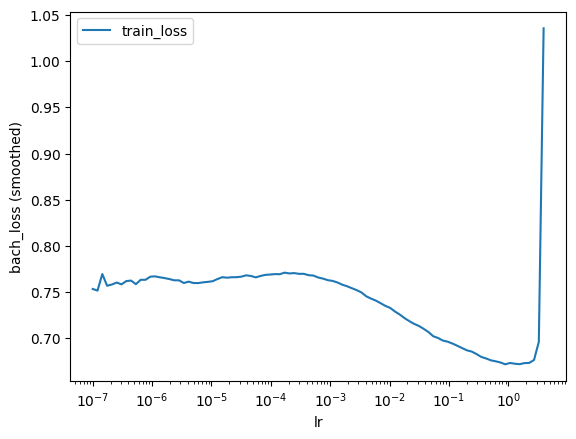

In [ ]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()
# Sometimes the optimal learning rate by this methos is too high. If it is higher than 0.01, we set this as the max value

np.float64(0.08902150854450441)

In [ ]:
model.optimizer.set_lr(0.1)

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat()) # validation data is repeated to match the time dimension of the model (since CoxTime is time-dependent

/usr/local/lib/python3.12/dist-packages/torchtuples/tupletree.py:597: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.tuple_.apply(lambda x: x[index])


0:	[0s / 0s],		train_loss: 0.7454,	val_loss: 0.9915
1:	[0s / 0s],		train_loss: 0.6417,	val_loss: 1.0798
2:	[0s / 0s],		train_loss: 0.6003,	val_loss: 1.1003
3:	[0s / 0s],		train_loss: 0.5941,	val_loss: 0.9140
4:	[0s / 0s],		train_loss: 0.5844,	val_loss: 0.7970
5:	[0s / 0s],		train_loss: 0.5902,	val_loss: 0.8482
6:	[0s / 0s],		train_loss: 0.5870,	val_loss: 0.7891
7:	[0s / 0s],		train_loss: 0.5653,	val_loss: 0.8000
8:	[0s / 0s],		train_loss: 0.5757,	val_loss: 0.7683
9:	[0s / 0s],		train_loss: 0.5702,	val_loss: 0.7808
10:	[0s / 0s],		train_loss: 0.5399,	val_loss: 0.7907
11:	[0s / 1s],		train_loss: 0.5873,	val_loss: 0.7270
12:	[0s / 1s],		train_loss: 0.5661,	val_loss: 0.7402
13:	[0s / 1s],		train_loss: 0.5424,	val_loss: 0.8136
14:	[0s / 1s],		train_loss: 0.5540,	val_loss: 0.7759
15:	[0s / 1s],		train_loss: 0.5444,	val_loss: 0.7768
16:	[0s / 1s],		train_loss: 0.5449,	val_loss: 0.7887
17:	[0s / 1s],		train_loss: 0.5670,	val_loss: 0.7402
18:	[0s / 2s],		train_loss: 0.5697,	val_loss: 0.7528
19:

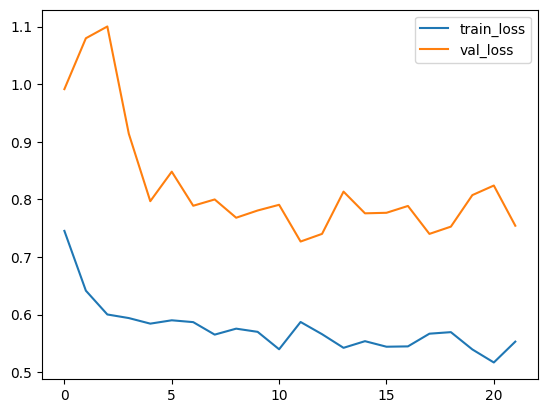

In [ ]:
_ = log.plot()

In [ ]:
model.partial_log_likelihood(*val).mean()

np.float32(-4.962786)

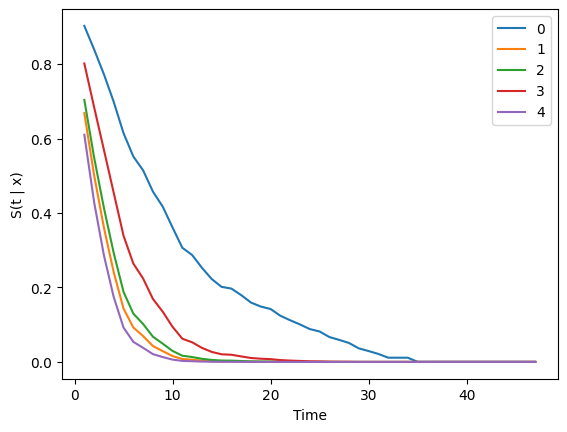

In [ ]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

**When to use: If hazard ratios vary or survival curves cross**

DeepSurv (CoxPH) assumes that, for example, being a “military leader” always multiplies your hazard (risk of losing power) by the same factor over your whole career. <br>
→ Once risky, always risky.

CoxTime, in contrast, can learn that military leaders are at higher risk early on, but their risk decreases as they stabilize power. <br>
→ Risk profile evolves with time.

### DeepHit

 - A discrete-time neural survival model.
 - Instead of assuming continuous time, it divides time into bins and predicts the probability of an event occurring in each bin.
- Handles competing risks — e.g., different possible event types (death, relapse, resignation, etc.).
- Uses a cross-entropy loss over time bins.
- A full probability distribution P(T=t∣x).
- Can model multiple event types at once.

In [ ]:
import numpy as np
import pandas as pd
from pycox.datasets import metabric
from pycox.models import DeepHitSingle
import torchtuples as tt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pycox.evaluation import EvalSurv
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

In [ ]:
df = metabric.read_df()
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


In [ ]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']
standardize = [([col], StandardScaler()) for col in cols_standardize]

x_mapper = ColumnTransformer(
    [(col, StandardScaler(), [col]) for col in cols_standardize],
    remainder='passthrough'
)
x = x_mapper.fit_transform(df)

durations = df['duration'].values
events = df['event'].values

np.random.seed(42)
idx = np.arange(len(df))
np.random.shuffle(idx)
split = int(0.8 * len(df))  # 80% train, 20% test
train = idx[:split]
test = idx[split:]

x_train, x_test = x[train], x[test]
y_train, y_test = durations[train], durations[test]
e_train, e_test = events[train], events[test]

In [ ]:
num_durations = 50
labtrans = DeepHitSingle.label_transform(num_durations)

y_train_transformed = labtrans.fit_transform(y_train, e_train)
y_test_transformed = labtrans.transform(y_test, e_test)

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle(net, tt.optim.Adam)

In [ ]:
batch_size = 256
epochs = 50

callbacks = [tt.callbacks.EarlyStopping(patience=5)]
verbose = True

model.fit(x_train, y_train_transformed, batch_size, epochs, callbacks, verbose, val_data=(x_test, y_test_transformed))

0:	[0s / 0s],		train_loss: 0.8281,	val_loss: 0.7336
1:	[0s / 0s],		train_loss: 0.7357,	val_loss: 0.6545
2:	[0s / 0s],		train_loss: 0.6690,	val_loss: 0.6042
3:	[0s / 0s],		train_loss: 0.6199,	val_loss: 0.5632
4:	[0s / 0s],		train_loss: 0.5874,	val_loss: 0.5319
5:	[0s / 0s],		train_loss: 0.5621,	val_loss: 0.5095
6:	[0s / 0s],		train_loss: 0.5377,	val_loss: 0.4918
7:	[0s / 0s],		train_loss: 0.5246,	val_loss: 0.4775
8:	[0s / 0s],		train_loss: 0.5076,	val_loss: 0.4665
9:	[0s / 0s],		train_loss: 0.4948,	val_loss: 0.4581
10:	[0s / 0s],		train_loss: 0.4845,	val_loss: 0.4508
11:	[0s / 0s],		train_loss: 0.4759,	val_loss: 0.4443
12:	[0s / 0s],		train_loss: 0.4661,	val_loss: 0.4383
13:	[0s / 0s],		train_loss: 0.4618,	val_loss: 0.4319
14:	[0s / 0s],		train_loss: 0.4552,	val_loss: 0.4265
15:	[0s / 0s],		train_loss: 0.4499,	val_loss: 0.4215
16:	[0s / 0s],		train_loss: 0.4432,	val_loss: 0.4171
17:	[0s / 1s],		train_loss: 0.4363,	val_loss: 0.4129
18:	[0s / 1s],		train_loss: 0.4303,	val_loss: 0.4100
19:

In [ ]:
!pip install --upgrade scipy

C-index: 0.547


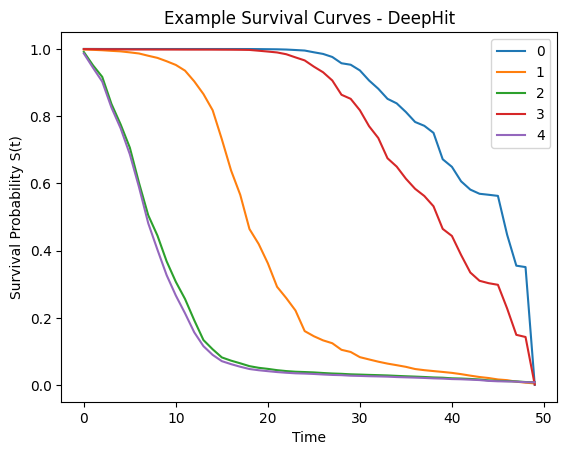

In [ ]:
# Predict survival function for test set
surv = model.predict_surv_df(x_test)

# Evaluate
ev = EvalSurv(surv, y_test, e_test, censor_surv='km')
c_index = ev.concordance_td()

print(f"C-index: {c_index:.3f}")

# Plot survival curves for a few patients
surv.iloc[:, :5].plot()
plt.ylabel("Survival Probability S(t)")
plt.xlabel("Time")
plt.title("Example Survival Curves - DeepHit")
plt.show()

In [ ]:
for i in range(5):
    print(f"Patient {i+1}:")
    print("Observed time:", y_test[i])
    print("Event occurred:", e_test[i])
    print("-" * 40)

Patient 1:
Observed time: 271.33334
Event occurred: 0
----------------------------------------
Patient 2:
Observed time: 135.3
Event occurred: 1
----------------------------------------
Patient 3:
Observed time: 59.7
Event occurred: 1
----------------------------------------
Patient 4:
Observed time: 263.6
Event occurred: 1
----------------------------------------
Patient 5:
Observed time: 50.766666
Event occurred: 1
----------------------------------------


### Deep Survival Machines (DSM)

- A mixture density model for survival analysis.
- Think of it as combining several survival “experts” — each representing a possible survival mode — and learning a mixture of Weibull or Log-Normal distributions.
- The network learns both the mixture weights and distribution parameters.
- Handles multi-modal survival distributions.
- Works even when hazards are not proportional and nonlinear.

### Nnet-Survival

- Another discrete-time survival model.
- Divides time into bins, predicts probabilities for each bin, and enforces that the survival probability decreases monotonically over time.
- Uses a neural network with cross-entropy loss (not Cox loss).

Compared to DeepHit:

- Simpler, single-risk, no competing events.
- Easier to implement; used when time discretization is acceptable.

### RNN / Transformer-based survival models

- For longitudinal or sequential data (e.g., patient visits, leader-year data, etc.).
- Input = sequence of feature vectors over time.
- Uses RNNs (LSTM, GRU) or Transformers to model temporal dependencies.
- Predicts survival dynamically as new information arrives.

Examples:

- Dynamic-DeepHit (RNN-based extension of DeepHit)
- TransformerSurv (uses attention for temporal survival data)